<a href="https://colab.research.google.com/github/N534H699/MachineLearning_Learn/blob/main/MakeMore_BiGram_ContextAdded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# RECALL: Previously done with a Freq Table with Single Prev Char (then used NN)
# BUT, if want more than one Prev Char, possible combos explodes (# Rows, e.g. 27 * 27 if 2 Char Context = 729 Possibilities... if 3 prev chars, then 27*27*27 = 19,683 possibilities of Context) -> Way too many Rows, too few Counts for each Possibility
# SO, will implement Multi Layer Perceptron (MLP) Model -- Was known back in 2003 when Research Paper released (fairly old approach)
# Still sticking with Characters here (not Word-Level Language Model)

# Approach: Each Token will have associated Feature Vector (e.g. 30 Dimensional)
# ... So, every (one of the e.g. 17k) Token embedded in a e.g. 30D Space (crowded, lots points for that small of space)
# ... Starts out spread out (Tokens init randomly), Training will Tune these Embeddings of these Words via Back Propagation
# ... I.e. These Vectors will move around in the space, Similar Tokens (e.g. Words) end up near each other (can Transfer Knowledge through the Embedding Space thanks to this, i.e. a Word next to another perhaps has similar meaning, such as "the" and "a")

# Modeling Approach: Multi-Layer NN, trained via Maximizing Log Likelihood of the Training Data
# ... Input Layer: FIRST Index into Matrix C w/ one of each Prev Tokens want take in (e.g. if 17k words, each input is INDEX of Token/Work, so input ranges 0-16999).
# ... - Input Layer # Neurons = (1 per Prev Word * someVal) E.g. 3 Prev Words, each w/ Lookup Table corresponding to 30 cols in a Row, so 30 Neurons rep per Prev Word, total of 3 * 30 = 90 Neurons in total
# ... - Lookup (Embedding) Table C (# Tokens x someVal, e.g. 17k x 30) -> Every Index Input is plucking out Row of Embedding Matrix C, each Index converted to the 30 Dim Vector that corresponds to the Embedding Vector for that word.
# ... --- Shared across all the Words (always indexing into same Matrix C over and over for each Word)
# ... - Input goes through Embedding Layer to get actual Input to NN (e.g. 3 Prev Words, 30 Neurons per Word for each entry in corresponding Row Vec, 30 * 3 = 90 Neurons in Input Layer)
# ... Hidden Layer: Fully Connected. # Nuerons is a HyperParam can tweak. TanH Non-Linearity applied.
# ... Output Layer: SoftMax (Probability o/p). Fully Connected Layer w/ 1 Neuron per Token (e.g. 17k Words that could come "next", then 17k Neurons) -> EXPENSIVE LAYER (most computation)
# ... - Logits go in SoftMax, get exponentiated & normalized (to sum to one so have Probability Distribution for next Token in Sequence) -> And during Training we have the Label, thus can use its Index to pluck out Probability of that Token from NN Output, then we max that Token's Probability w.r.t the Params of that NN -> Optimized via Back Propagation
# The Parameters of the NN are the Weights and Biases of the Output Layer, Hidden Layer, and Embedding Lookup Table (C) -> All these Params Optimized via Back Propagation

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # For Figures
%matplotlib inline

In [ ]:
# Same setup as before

# This time, downloading names.txt so not need manually add
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

# Read all Words in
words = open( 'names.txt', 'r' ).read().splitlines()
print( f"Word Count: {len(words)}" ); print( words[:5] ) # Verify words is populated

--2023-07-04 22:39:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-07-04 22:39:04 (7.37 MB/s) - ‘names.txt’ saved [228145/228145]

Word Count: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [ ]:
# Build Vocabulary of Chars and Map Functions to/from Ints
chars = sorted(list(set( ''.join(words) )))

stoi = { s:i+1 for i,s in enumerate(chars) } # +1 to leave space for '.' at [0] (for ease of use and easy distinction of '.' from letters)
stoi['.'] = 0 # Start/Stop Char

itos = { i:s for s,i in stoi.items() }
print(stoi['f'], itos[stoi['f']]);

6 f


In [ ]:
# Build DataSet for Model

block_size = 3 # "Context Length" (# Prev Chars NN take in to predict next) -- Can modify as desired for Context Length
X, Y = [], [] # Inputs / Output

#for w in words[:5]: # Start with only 5 Words
for w in words: # All da Words
  context = [0] * block_size # Sliding Window inits to "..." (i.e. Index 0)
  for char in w + '.':
    ix = stoi[char]

    X.append( context )
    Y.append( ix )

    #print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
    context = context[1:] + [ix] # Sliding Window shifts 1

X = torch.tensor(X)
Y = torch.tensor(Y)

print( "X Shape/Type: ", X.shape, X.dtype )
print( "Y Shape/Type: ", Y.shape, Y.dtype )

X Shape/Type:  torch.Size([228146, 3]) torch.int64
Y Shape/Type:  torch.Size([228146]) torch.int64


In [ ]:
# === Construct Input Layer

# Build Embedding Lookup Table C
# 27 Characters, embedding in some smaller Dimensional (e.g. 17k Words/Tokens into 30 Dimensional Space)
# For us, embed in 2D space. Each one of 27 Chars has 2D Embedding (27 x 2 Matrix C)
# C initially randomized
C = torch.randn( (27,2) )

# NOTE: Size of Embeddings is also a Hyper Parameter
# -- Something like only 2 Dimensional Embeddings may be too small (Neural Net isn't able use that space effectively)
# ---- Will see this come up later, but using 2 for now

# One way can Embed... Direct Index e.g. 5, C[5] -> Gives Embedding Vector for Row X
# Previously, we took Int and did OneHot Encoding ( F.one_hot(torch.tensor(5), num_classes=27) -> Vector (27 elems) of 0s except 5th Element. 5 has to be wrapped in a Tensor)
# If do oneHotVector.float() @ C (need .float() since oneHot is 64 Bit Int)
# ... GET SAME RESULT if do C[5] -> I.e. Matrix Mult "plucks out" 5th Row (which is 1 bit in oneHotVector, rest are 0s)
# ... THUS, can think of our (embedding of Vector) oneHotVector @ C like indexing into C AND is first Layer of a bigger Neural Network -> w/ Layer of Linear Neurons with Weight Matrix of C
# ... We will Index for speed (not consider the oneHot interpretation)

# How simultaneously embed all Examples (e.g. 32 x 3 ints in Array X, 32 examples w/ Context Length 3)?
# ... Can INDEX with a LIST in Torch, or even w/ Tensor. E.g. C[[1,2,3]] or C[torch.tensor[1,2,3]]
# ... Can Index w/ MultiDim Tensors of Ints. Exactly what X is...
# ... ... So, can do C[X] -> 32x3 x 2 (orig 32x3, now w/ each entry having a 2 elem Embedding Vector)
# ... ... E.g. X[13, 2] Example Index 13, 2nd Dim is Int 1 (tensor(1))
# ... ... So now, E.g. C[X][13,2] -> gives Embedding for it -> e.g. tensor([ 1.0815, -0.3502] ) (still randomized)
# ... C[5] -> 5th Row of C... C[X] -> Gets all Embeddings (Shape: [32, 3, 2])
# ... ... SO, C[X][13,2] is indexing the first 2 Dims ([13,2] of ^), and getting that specific entry, Example Index 13 2nd Context Index
# ... ... Which is same as C[1] (which is what X[13,2] gives, i.e. tensor(1))
# SO can simply do:
embedding = C[X] # X is 32x3 (32 exps, 3 context length), C[X] assoc each Char in X (each in Context too) w/ Embedding
embedding.shape

torch.Size([228146, 3, 2])

In [ ]:
# === Construct Hidden Layer

# Number Inputs to Hidden Layer is 2 Dim Embeddings per Input Layer Neuron, and 3 Neurons in Input Layer (3*2)
# Number Neuron in Hidden Layer is up to us (e.g. 100)
W1 = torch.randn( (3*2, 100) )
b1 = torch.randn( 100 ) # Biases (1 per Neuron on Hidden Layer)

# Want do something like: (embedding @ W1) + b1
# BUT, Embeddings are stacked up in the Dimensions of the embedding Tensor (shape of 32x3x2 and can't mult that by 6x100)
# Need transform 32x3x3 into 32x6 so can perform the Multiplication
# Many ways can do this, some faster/shorter/etc. -> Torch has lots of Functions can call in Tensors (add, mult, create, concat, etc.)
# ... torch.cat (Concatenates seq of Tensors in Given Dimension)
# ... Can use ^ to Concatenate the 3 Embeddings for each Input

# Grab all Examples, 0th Index, & all of 3rd Dimension -> Pluck out 32x2 Embeddings of just the first Token
# Repeat for 1st Index and 2nd Index (each representing Neuron in Neural Network's Input Layer)

# POOR CODE due to hard-coding Context Length (assumes 3)
#sequenceOfTensors = [embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]]
#torch.cat( sequenceOfTensors, 1 ) # Cat the Sequence of Tensors together along Dimension [1] (since 32x2 and want concat along the 2s Dimension)

# ONE ALT (independent of Context Length):
#torch.cat( torch.unbind(embedding, 1), 1 )  # Removes a Tensor Dimension and returns a Tuples of all Slices along a given Dimension, without it -- I.e. above we singled out the index of the [1] Dimension manually, here, we can do so for ALL in Embedding Tensor
# -- INEFFICIENT THOUGH, Concatenation will create entirely new Memory (new Tensor w/ all new Storage since no way to Concatenate Tensors by just manipulating View Attributes)

# BETTER WAY (Can re-represent a Tensor as different Size N-Dim Vectors, such as instead of a single Vector of 18 Elements, it can be made a 3x3x3 or 2x9 or 9x2 Tensor... -> Done via Views, as long as total # Elements when Mult together Dim Sizes, is the same):
# -- EFFICIENT cuz "Underlying Storage of Tensor" is rep as 1 Dimensional Vector in memory, calling "View" manipulated some Attributes of Tensor that dictates the Dimensions of the Tensor -> NO MEMORY CHANGED/COPIED/CREATED (Storage is Identical, just Internal Attributes of View of Tensor is manipulated, such as Storage Offset, Strides, and Shape)
##a = torch.arange(18)
##print( a.view(3,3,2) ); # 3*3*2=18 elements still can do a.view(9,2)

# So, can do this with the Emebedding Matrix (Shape of 32x3x2, can ask PyTorch view as 32x6)
#embedding.view(32, 6) # The way this gets flattened to 32x6 causes the "2" Dimension to get "Concatenated" into single row -> SAME RESULT AS LAST "torch.cat(...)"
# TEMPORARY though, only returns Tensor with the Metadata changed, not persists within "embedding"
# Shape would be a 32 x 6, where the 3x2 of 32x3x2 is brought together to be a 6 element row


# PUTTING IT ALL TOGETHER -> Can now do the Multiple we wanted to
#testH = embedding.view(32, 6) @ W1 + b1 # WORKS (viewing 'embedding' as 32x6)
#testH = embedding.view( embedding.shape[0], 6 ) # ^^ Still applies ,but not hard-coding 32.
# COULD ALSO DO "-1" instead of "embedding.shape[0]", which will cause PyTorch to Infer what it must be (since # Elements must be the same, if say second Dim is 6, then it will figure out the Dimension it must be to make Multiplication work)
#print(testH.shape) # NOW 32x100, 100, 1 for Activation for each of our 32 Examples

# True for all Elements (Element-wise Equality)
#print( embedding.view(32,6) == torch.cat(torch.unbind(embedding, 1), 1) )


# So, all that allows us to do...
# Broadcasting allows this (aligns on right, creates fake Dimension "1" (1x100 Row Vector), then copies that Row Vector Vertically for every one of the 32 Rows of the other -> I.e. Same Bias Vector Added to all Rows of the Matrix, which is what we want)
# 32, 100
#  1, 100
h = torch.tanh( embedding.view(-1, 6) @ W1 + b1 ) # Using "-1" insead of of embedding.shape[0] -> So PyTorch will Infer Size based on what'll make Matrix/Vector Multiplication Work


In [ ]:
# === Construct Output Layer
W2 = torch.randn( 100, 27 ) # Input 100, Output # Neurons = 27 (since 27 possible Characters that come next)
b2 = torch.randn( 27 )


logits = h @ W2 + b2 # Currently, with our first 5 Words, 32 x 27

############### Can be replaced w/ Cross Entropy ###############
# As before, exponentiate logits to get "Fake Counts", and continue w/ SoftMax
counts = logits.exp()
probabilities = counts / counts.sum(1, keepdims=True) # Along 1st Dimension
print(probabilities.shape) # (originally) 32 x 27 (numExamples x posNextChar)
#probabilities[0].sum() # Each Row Sums to 1 (i.e. now Normalized)

exampleCount = X.shape[0]
loss = -probabilities[torch.arange(exampleCount), Y].log().mean()
################################################################

# NOTE: Instead of `logits` through `loss` above, could use Cross Entropy (combines )
# - FAR MORE EFFICIENT. Since no Intermediate Tensors created (all .log().mean() create new Tensors in Memory)
# -- PyTorch clusters up all these Ops and often use Fused Kernels to efficiently eval these Expressions (Clustered Mathematical Operations)
# -- Analyticly and Mathematically it's a simpler Backward Pass to calculate (and thus implement)
# --- E.g. (e^(2*x) - 1) / (e^(2*x) + 1) far more complicated Mathematical Expression than say (1 - t^2)
# -- Cross Entropy tends be more well-behaved (Mathematically)
# ---- E.g. logits = tensor([-2,3,0,5]), fine, but what if tensor([-100, -3, 0, 5]) -- More extreme values (possible during optimization of NN)
# ------ Because logits.exp() (which is e^somePow) will cause issues if have +100 in ^ due to logits.exp() (neg causes 1 / e^somePow = fine) Tensor containing an "inf" because run out of range in Floating Point Number (e^100 -> "inf" val due to out of range can represent #)
# ------ PyTorch sovles this by offset Logits by some (same) arbitrary constant (any offset shared, produces same probabilities ultimately) -> PyTorch subtracts the Max Value, which makes largest # 0, and all else Negative, so exp() behaves appropriately (only causes issues on large Positive #s)
# Cross Entropy finds difference between 2 Distributions
# - Distribution of Model Predictions (logits)
# - Distribution of Training Data (Y)
loss = F.cross_entropy( logits, Y )


torch.Size([228146, 27])


In [ ]:
# ====================== SIMPLIFIED ======================

g = torch.Generator().manual_seed(2147483647) # For Consistency/Reproducibility

# Input Layer
C = torch.randn( (27,2), generator=g )
embedding = C[X]


# Hidden Layer
hiddenLayerNeuronCount = 100
W1 = torch.randn( (3*2, hiddenLayerNeuronCount), generator=g )
b1 = torch.randn( hiddenLayerNeuronCount, generator=g )

h = torch.tanh( embedding.view(-1, 3*2) @ W1 + b1 ) # E.g. (32, 100)


# Output Layer
W2 = torch.randn( (hiddenLayerNeuronCount, 27), generator=g )
b2 = torch.randn( 27, generator=g )

logits = h @ W2 + b2 # 32 x 27
#counts = logits.exp()
#probabilities = counts / counts.sum( 1, keepdims=True )
#loss = -probabilities[ torch.arange(32), Y ].log().mean()
loss = F.cross_entropy( logits, Y )

print( loss )


tensor(19.5052)


In [ ]:
# =============================================================================
# =================================== RESET ===================================
# =============================================================================
# Quick Re-Init of Model Parameters

C = torch.randn( (27,2), generator=g )

hiddenLayerNeuronCount = 100 # HyperParam
W1 = torch.randn( (3*2, hiddenLayerNeuronCount), generator=g ) # Input = hiddenLayerNeuronCount, Output = 3*2 (3 Neurons, each with 2 Embedded Values)
b1 = torch.randn( hiddenLayerNeuronCount )

W2 = torch.randn( (hiddenLayerNeuronCount, 27), generator=g )
b2 = torch.randn( 27, generator=g )


# Ensure all Params Require Gradient (to be calc by Torch) -- Repeating here for Convenience.
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [ ]:
# ======================== Training Loop ========================
# NOTE: ReRun above Block of Code to reinit all Parameters

# Save Parameters to loop over later (e.g. set Grad to None)
parameters = [C, W1, b1, W2, b2]
print(f"Parameter Count: {sum(p.nelement() for p in parameters)}") # 3481 Parameters

for p in parameters:
  p.requires_grad = True


#for i in range(1000): # Takes a while cuz on FULL DataSet
for i in range(10):

  embeddings = C[X]

  h = torch.tanh( embeddings.view(-1, 3*2) @ W1 + b1 )

  logits = h @ W2 + b2

  loss = F.cross_entropy( logits, Y )
  print( f"Loss on Iteration {i} = {loss}" )

  # Reset
  for p in parameters:
    p.grad = None

  loss.backward() # Populate the Gradients

  # Update
  for p in parameters:
    p.data += -0.1 * p.grad

# Will be SMALL if not many Examples, cuz easy to Overfit (only 32 Examples but 3481 Params))
# Can't be exactly 0 cuz multiple Examples have same Target (e.g. ...->e, ...->o, ...->a, ...->i, ...->s  i.e. multiple possibilities to follow Context="...")
# Loss is very low or 0 for cases that have unique Input for Unique Ouptut, such as "oli"->v, which appears once in first 5 Examples
print(f"Final Loss = {loss}")


Parameter Count: 3481
Loss on Iteration 0 = 14.742026329040527
Loss on Iteration 1 = 13.952454566955566
Loss on Iteration 2 = 13.301827430725098
Loss on Iteration 3 = 12.680068969726562
Loss on Iteration 4 = 12.080190658569336
Loss on Iteration 5 = 11.605718612670898
Loss on Iteration 6 = 11.283839225769043
Loss on Iteration 7 = 11.156293869018555
Loss on Iteration 8 = 10.670614242553711
Loss on Iteration 9 = 10.348132133483887
Final Loss = 10.348132133483887


In [ ]:
# This takes a WHILE since we're going over entire DataSet EVERY ITERATION (and tanH w/ Matrix Multiplication is on large Matrices, and all the Back Propagation being done, with large amounts of Data)
# In Practice, we tend use Mini Batches instead, where we Train on a Mini Batches only (subset of Training Set)
# Forwarding / Backwarding LOTS of Examples (~228k Examples)

# SO, randomly select some Portion of DataSet, use as Mini Batch (each Iteration)
# Only Forward / Backward / Update on that Mini Batch, then iterate on the Mini Batches

# NOTE: Mini Batch Gradient less reliable (direction not necessarily actual Gradient Direction)
# ... Mini Batch Gradient is less Quality than Exact Gradient
# ... BUT, this works well in practice.
# ... Better have an Approx Gradient and take more Steps, than evaluate Exact Gradient and take fewer Steps


In [ ]:
# ======================== Training Loop ========================
# ======================= WITH MINI BATCH ========================
# NOTE: ReRun above Parameter Block of Code to reinit all Parameters

# Save Parameters to loop over later (e.g. set Grad to None)
parameters = [C, W1, b1, W2, b2]
print(f"Parameter Count: {sum(p.nelement() for p in parameters)}") # 3481 Parameters

for p in parameters:
  p.requires_grad = True


miniBatchSize = 32


for i in range(1000): # FASTER now cuz using single Mini Batch

  # Construct Mini Batch
  # Range 0 to however many Examples there are (i.e. serves as Index into X)
  # And there's miniBatchSize many of them
  ix = torch.randint( 0, X.shape[0], (miniBatchSize,) ) # 32 Elements


  # Forward Pass

  # Grab Mini Batch (by indexing X w/ ix to get only miniBatchSize many Rows of X)
  embeddings = C[X[ix]] # Now (32, 3, 2) -> 32 Examples in Mini Batch

  h = torch.tanh( embeddings.view(-1, 3*2) @ W1 + b1 )

  logits = h @ W2 + b2

  loss = F.cross_entropy( logits, Y[ix] ) # Mini Batch Index into Y to get associated Ys
  #print( f"Loss on Iteration {i} = {loss}" )


  # Backward Pass

  # Reset
  for p in parameters:
    p.grad = None

  loss.backward() # Populate the Gradients

  # Update
  for p in parameters:
    p.data += -0.1 * p.grad # NOT CLEAR IF 0.1 is good Learning rate -> SEE NEXT SECTION BELOW

# Will be SMALL if not many Examples, cuz easy to Overfit (only 32 Examples but 3481 Params))
# Can't be exactly 0 cuz multiple Examples have same Target (e.g. ...->e, ...->o, ...->a, ...->i, ...->s  i.e. multiple possibilities to follow Context="...")
# Loss is very low or 0 for cases that have unique Input for Unique Ouptut, such as "oli"->v, which appears once in first 5 Examples

# Due to Mini Batch, loss here only reflects last Mini Batch ...
#print(f"Final Loss = {loss}")


# FINALLY...
# ... Want the Loss on whole Training Set, so recalculate that
embedding = C[X]
h = torch.tanh( embedding.view(-1, 3*2) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy( logits, Y )
print(f"Final Loss = {loss}")


Parameter Count: 3481
Final Loss = 2.708108901977539


In [ ]:
# ========================== Learning Rate Adjustment ==========================

'''
How Determine Reasonable Learning Rate

A) Trial/Error
- Set iterations (# Steps) to something fairly low, not too low (e.g. 100)
-- Print Loss at each Step
- Find a reasonable Search Range (e.g. Learning Rate between -0.001 and -1)
-- Done by trying Learning Rates, e.g. -0.0001 at first
-- Each Step, check if Loss decreasing sufficiently (not too slow)
---- Find the Learning Rate that consistently decreases Loss (but not quickly) -> THAT IS LOWER BOUND
---- Find Learning Rate where it decreases fast (but doesn't "explode", meaning may go from 70 to 60 then 90 Loss again) -> UPPER BOUND
---- THESE are LOWER and UPPER Bounds
-- Reset all Params (e.g. Weights) after each Trial

- Use torch.linspace( lower, upper, numberOfSteps ) to get 1000 #s between lower and upper (linearly)
-- E.g. torch.linspace( 0.001, 1, 1000 ) -> 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, ... 0.170, 0.171, ...
-- Not make sense to step between lower/upper linearly BECAUSE(?) want bias towards upper end (???)
-- SO:
--- learningRateExp = torch.linspace( -3, 0, 1000 ) -> 10 ^ -3 = 0.001 and 10 ^ 0 = 1
--- learningRates = 10 ** learningRateExp
--- RESULT: learningRates are spread out EXPONENTIALLY in Interval [lower, upper]

'''

# Learning Rate Sampling Now Applied
learningRateExponents = torch.linspace( -3, 0, 1000 )
learningRates = 10 ** learningRateExponents


# Variables to track stats for later reflection
learningRates_i = []
learningRateExponents_i = []
loss_i = []

MINI_BATCH_SIZE = 32

for i in range(1000): # Number Steps corresponds to Number Learning Rates

  # Create Mini Batch
  ix = torch.randint( 0, X.shape[0], (MINI_BATCH_SIZE,) )

  embeddings = C[X[ix]] # 32x3 x 2


  # Hidden Layer
  h = torch.tanh( embeddings.view(-1, 3*2) @ W1 + b1 ) # 32 x 100


  # Output Layer
  logits = h @ W2 + b2 # 32 x 27
  loss = F.cross_entropy( logits, Y[ix] );
  print( loss.item() )


  # Backward Propagation
  for p in parameters:
    p.grad = None

  loss.backward()

  learningRate = learningRates[i]
  for p in parameters:
    p.data += -learningRate * p.grad


  # Track Stats for later Plotting
  learningRates_i.append( learningRate )
  learningRateExponents_i.append( learningRateExponents[i] )
  loss_i.append( loss.item() )




2.5679523944854736
2.9284276962280273
2.983466386795044
2.614595651626587
2.585796594619751
2.4752495288848877
2.8201937675476074
2.885814666748047
2.5642459392547607
2.5582613945007324
2.5855941772460938
2.622565269470215
2.2134814262390137
2.5761189460754395
2.3638997077941895
2.4927196502685547
3.07482647895813
2.721318483352661
2.3579747676849365
2.2258832454681396
3.088027000427246
3.336595058441162
2.654057264328003
2.533184766769409
2.5678675174713135
2.8380463123321533
2.78670334815979
2.6585259437561035
2.794635772705078
2.871967315673828
2.7765238285064697
2.8395583629608154
2.617410659790039
2.7927017211914062
2.6649622917175293
3.1293723583221436
2.6890275478363037
2.6245038509368896
2.385080575942993
3.092694044113159
2.6276090145111084
2.571617841720581
2.525383949279785
2.7415997982025146
2.574552297592163
2.2509987354278564
2.5930943489074707
2.4673244953155518
2.724018096923828
2.554866075515747
2.990338087081909
2.6822457313537598
2.638437032699585
2.5009329319000244


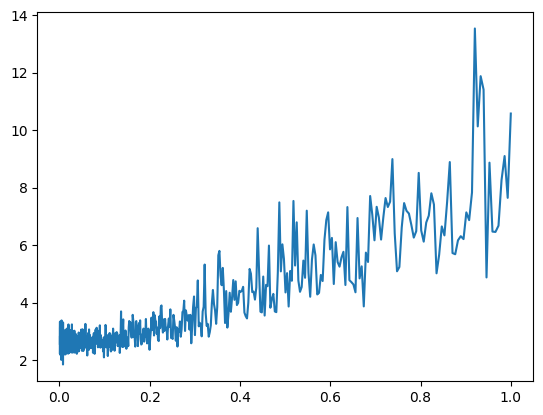

In [ ]:
# This shows Learning Rates we used on X Axis, then Y Axis has the Loss we observed w/ that Learning Rate
# COMMON PATTERN
# At first, very low Learning Rate, gradually decreased Loss as increased Learning rate
# Got to a good spot around 0.1, then as increased Learning Rate even more, Loss blew up
# After a certain point of increasing Learning Rate, the Loss Exploded (became very unstable)
plt.plot( learningRates_i, loss_i ) # Learning Rate only

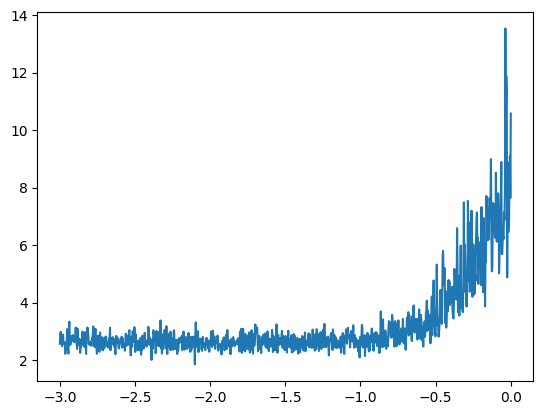

In [ ]:
plt.plot( learningRateExponents_i, loss_i ) # Learning Rate Exponents

# This shows which Exponent of Learning Rate to use, somewhere around min / valley
# For our setup, shows around -1 is good Exponent (10 ^ -1 = 0.1, which is our original we used, which was good)

In [ ]:
# NOW, can apply our ideal Learning Rate (0.1), add far more steps (e.g. 10k, repeated 2 or 3 times to see if Loss continues to go down)
# Once Loss seems to have converged, and plateaus, can "Learning Rate Decay" by dropping Learning Rate a bit, to something like 0.01 from 0.1 (e.g. drop by factor 10) -> Potentially improves Loss even more

MINI_BATCH_SIZE = 32

for i in range( 10000 ): # Can crank up higher now (e.g. 10000)

  # Create Mini Batch
  ix = torch.randint( 0, X.shape[0], (MINI_BATCH_SIZE,) )
  embeddings = C[X[ix]] # 32x3 x 2


  # Hidden Layer
  h = torch.tanh( embeddings.view(-1, 3*2) @ W1 + b1 ) # 32 x 100


  # Output Layer
  logits = h @ W2 + b2 # 32 x 27
  loss = F.cross_entropy( logits, Y[ix] );


  # Backward Propagation
  for p in parameters:
    p.grad = None

  loss.backward()

  #learningRate = 0.1 # The Ideal Larning Rate we saw -- RAN WITH 2-3 times
  learningRate = 0.01 # Learning Rate Decay  (10x lower it) -- RAN WITH 2-3 times
  for p in parameters:
    p.data += -learningRate * p.grad


# Check Resulting Loss
embeddings = C[X] # 32x3 x 2
h = torch.tanh( embeddings.view(-1, 6) @ W1 + b1 ) # 32 x 100
logits = h @ W2 + b2 # 32 x 27
loss = F.cross_entropy( logits, Y )
print( loss.item() )

2.3155136108398438


In [ ]:
# ========================= DUPLICATED FOR CONVENIENCE =========================
# ==============================================================================
# =================================== RESET ====================================
# ==============================================================================
# Quick Re-Init of Model Parameters

C = torch.randn( (27,2), generator=g )

hiddenLayerNeuronCount = 100 # HyperParam
W1 = torch.randn( (3*2, hiddenLayerNeuronCount), generator=g ) # Input = hiddenLayerNeuronCount, Output = 3*2 (3 Neurons, each with 2 Embedded Values)
b1 = torch.randn( hiddenLayerNeuronCount )

W2 = torch.randn( (hiddenLayerNeuronCount, 27), generator=g )
b2 = torch.randn( 27, generator=g )


# Ensure all Params Require Gradient (to be calc by Torch) -- Repeating here for Convenience.
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [ ]:
# - NOTE: This Loss gets down below 2.45 from original BiGram Model we had, now we're below 2.4 (doing better than BiGram Model)
# -- This isn't necessarily a better Model than the BiGram Model we had since 3481 Param Model (like we have here) is still a pretty small Model.
# ---- And as the Capacity or # Parameters grows, it becomes more capable of OVER FITTING Training Set -> I.e. LOWER LOSS, but just from memorizing Training Set (Loss on unseen Data can be very large)
# ---- This is where Validation Sets comes in
# -- This Model has sum( p.nelement() for p in parameters ) many Parameters (each C, W1, b1, W2, b2 have their own values, accumlating to total # Params, here it's 3481)

# Training Split (usually 80% of DataSet), Dev/Validation Split (10% of DataSet), Test Split (10% of DataSet)
# -- Training Set used to Optimize Model Parameters
# -- Validation Set used to "develop" the Model (tune Hyper Parameters, e.g. size of Hidden Layer, size of Embedding, etc.)
# ---- Can try variations of Hyper Parameters to find best
# -- Test Set used to evaluate Model Performance
# ---- Done sparingly and a few times! If do too much, Model starts to learn Test Split and it becomes less useful (risk Overfitting to Test Split)


# ============================== CHECKPOINT ====================================

# =========================== Data Set Splits ==================================
# NOW Split the Data into Training, Validation, and Test Splits

# Takes list of Words and builds Xs and Ys for those Words only
def build_dataset( words ):
  block_size = 3
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append( context )
      Y.append( ix )

      context = context[1:] + [ix] # Shift Context Window

  X = torch.tensor( X )
  Y = torch.tensor( Y )
  return X, Y

# Shuffle all the Words in our DataSet
import random
random.seed(42)
random.shuffle( words )

n1 = int( 0.8 * len(words) ) # n1 is first 80% of the Words
n2 = int( 0.9 * len(words) ) # n2 is next 90% of the Words (acts as 10% when used as range n1 to)

X_train, Y_train = build_dataset( words[:n1] )
X_dev, Y_dev = build_dataset( words[n1:n2] )
X_test, Y_test = build_dataset( words[n2:] )



In [ ]:
# Now put the Data Set Splits to use

# MODEL TRAINING -- Only uses Training Split
# NOTE: Usually not done in-line, usually launch bunch of Jobs and wait for them to finish (can often take multiple days with larger Models)


MINI_BATCH_SIZE = 32

for i in range( 10000 ): # Increasing Steps for faster training in one go (was 30k for initial, then dropped to 10k when Learning Rate Decayed, mainly for faster training)

  # Create Mini Batch
  ix = torch.randint( 0, X_train.shape[0], (MINI_BATCH_SIZE,) )
  embeddings = C[X_train[ix]] # 32x3 x 2


  # Hidden Layer
  h = torch.tanh( embeddings.view(-1, 3*2) @ W1 + b1 ) # 32 x 100


  # Output Layer
  logits = h @ W2 + b2 # 32 x 27
  loss = F.cross_entropy( logits, Y_train[ix] );


  # Backward Propagation
  for p in parameters:
    p.grad = None

  loss.backward()

  #learningRate = 0.1 # The Ideal Larning Rate we saw -- RAN WITH 2-3 times
  learningRate = 0.01 # Learning Rate Decay  (10x lower it) -- RAN WITH 2-3 times
  for p in parameters:
    p.data += -learningRate * p.grad

print( loss.item() )

2.2914910316467285


In [ ]:
# MODEL EVALUATING -- Using dev set here...

embeddings = C[X_dev] # 32x3 x 2
h = torch.tanh( embeddings.view(-1, 6) @ W1 + b1 ) # 32 x 100
logits = h @ W2 + b2 # 32 x 27
loss = F.cross_entropy( logits, Y_dev )

print( "Dev Loss:", loss.item() ) # Still pretty good Loss even know Model never seen these Examples yet


# Can compare to Training Loss to make sure we're not Overfitting (they're about equal, which is good)
# -- Model isn't powerful enough to Overfit the Data right now (to purely memorize data)
# -- We're right now "Underfitting" since Training Loss and Dev/Test Losses are roughly equal
# ---- Means our Model is very small. We can improve Performance by increasing Model size

embeddings = C[X_train] # 32x3 x 2
h = torch.tanh( embeddings.view(-1, 6) @ W1 + b1 ) # 32 x 100
logits = h @ W2 + b2 # 32 x 27
loss = F.cross_entropy( logits, Y_train )

print( "Train Loss:", loss.item() ) # Still pretty good Loss even know Model never seen these Examples ye


2.263089179992676
2.2664990425109863


In [ ]:
# ========================= INCREASING PARAMETER COUNT =========================
# ==============================================================================
# =================================== RESET ====================================
# ==============================================================================

# INCREASING MODEL SIZE (more Parameters)
# -- NOTE: With a larger Model, will take longer to Converge (more Steps & thus Training Time)
# -- NOTE: Bottlenecks can hinder Model's Performance growth (e.g. 2D Embeddings as Input may bottleneck Model from being able to represent much with them and keep from improving Performance)

C = torch.randn( (27,2), generator=g )

#hiddenLayerNeuronCount = 100 # HyperParam
hiddenLayerNeuronCount = 300 # HyperParam -- BUMPING UP to increase Model Size (~10k Params instead of ~3k Params)
W1 = torch.randn( (3*2, hiddenLayerNeuronCount), generator=g ) # Input = hiddenLayerNeuronCount, Output = 3*2 (3 Neurons, each with 2 Embedded Values)
b1 = torch.randn( hiddenLayerNeuronCount )

W2 = torch.randn( (hiddenLayerNeuronCount, 27), generator=g )
b2 = torch.randn( 27, generator=g )


# Ensure all Params Require Gradient (to be calc by Torch) -- Repeating here for Convenience.
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True


print( sum(p.nelement() for p in parameters) ) # Number of Parameters in Total

10281
